# Data Cleaning

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb

Firstly, load the data. The data set is wide and long, with 8378 rows and 195 columns.

In [148]:
dating_df = pd.read_csv("speed_dating_data.csv", encoding="ISO-8859-1")
dating_df.shape

(8378, 195)

### Select necessary columns
The data set is super wide, and there are so many variables. So we went through the codebook made by the creators of this data set and selected variables we currently think would be necessary for our future analysis. Now we still have 21 columns. 

Certainly, we won't use all of them at once in a logistic regression model. For example, demographic information about the participants such as "race" and "field" will be mainly used in descriptive statistics for us to know about the subject population and detect sampling bias of the study rather than using them as explanatory variables in the model.

In [149]:
select_list = ['iid', 'gender', 'wave', 'round', 'pid',
               'age', 'field_cd', 'race','career_c',
               'attr3_1','sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 
               'dec', 'attr', 'sinc','intel', 'fun', 'amb', 'shar']

dating_df = dating_df[select_list]
dating_df.shape

(8378, 21)

### Rename columns

Though we did not do any web scraping or merge data sets to get this data frame, one main effort we made was to interpret the meaning of each variable – carefully reading through the 15-paged codebook. We noticed that some of the names of the given variable names were vague. So, we decided to change them so they conveyed more straightforward information about the variables. 

In [150]:
dating_df = dating_df.rename(columns = {"iid":"id",
                                        "round": "num_dates", 
                                        "pid": "partner_id", 
                                        "dec": "decision",
                                        "attr3_1": "rate_self_attr", 
                                        "sinc3_1": "rate_self_sinc",
                                        "fun3_1": "rate_self_fun",
                                        "intel3_1": "rate_self_intel",
                                        "amb3_1": "rate_self_amb",
                                        "attr": "rate_p_attr",
                                        "sinc": "rate_p_sinc",
                                        "fun": "rate_p_fun",
                                        "intel": "rate_p_intel",
                                        "amb": "rate_p_amb",
                                        "shar": "rate_p_shar"})
dating_df.columns

Index(['id', 'gender', 'wave', 'num_dates', 'partner_id', 'age', 'field_cd',
       'race', 'career_c', 'rate_self_attr', 'rate_self_sinc', 'rate_self_fun',
       'rate_self_intel', 'rate_self_amb', 'decision', 'rate_p_attr',
       'rate_p_sinc', 'rate_p_intel', 'rate_p_fun', 'rate_p_amb',
       'rate_p_shar'],
      dtype='object')

### Remove biased observations
The researchers ran 21 speed dating sessions, or waves, in total. However, as they explained in their paper, they removed four sessions (waves 18-21) from the analysis "because they involved an experimental intervention where participants were asked to bring their favorite book. These four sessions were run specifically to study how decision weights and selectivity would be affected by an intervention designed to shift subjects’ attention away from superficial physical attributes. They are omitted so that the only experimental difference across sessions is group size." Accordingly we also removed data for these four sessions. 

The researchers also said they removed another wave (#12) because they "imposed a maximum number of acceptances" on participants of this wave. We thought this restriction would affect participants' decisions, so we also removed this wave.

In [151]:
dating_df = dating_df[~dating_df['wave'].isin([12, 18, 19, 20, 21])]
dating_df.shape

(6412, 21)

### Deal with missing values
We noticed there were many missing values due to how the experiment was designed and conducted. For each variable with more than 200 missing values, we re-examined whether we still thought it would be a potential good predictor in our future modeling given the fact that including it would mean fewer data points to train the model, which might make the model less robust. Finally we decided to remove the variable called "rate_p_shar," which was the dater's rating of shared interests/hobbies for the datee.

In [152]:
# count NAs for each column
for col in dating_df:
    n = sum(pd.isna(dating_df[col]))
    if (n > 0):
        print([col, n])

dating_df = dating_df.drop(["rate_p_shar"], axis = 1)

['partner_id', 10]
['age', 73]
['field_cd', 82]
['race', 63]
['career_c', 138]
['rate_self_attr', 105]
['rate_self_sinc', 105]
['rate_self_fun', 105]
['rate_self_intel', 105]
['rate_self_amb', 105]
['rate_p_attr', 130]
['rate_p_sinc', 196]
['rate_p_intel', 208]
['rate_p_fun', 260]
['rate_p_amb', 553]
['rate_p_shar', 874]


Next, let's see how many rows would be left if all rows with any missing values were dropped.

In [153]:
dating_df = dating_df.dropna()
dating_df.shape

(5601, 20)

From a statistical standpoint, a sample of 5601 datapoints would be good enough for logistic regression. We would also have enough for splitting it into training and test sets.

### Map coded categorical variables to their corresponding values

Some categorical variables were coded as integers (e.g., gender, field, race, career). This was for data storage and system performance reasons. For our purposes, we thought it would be better if these variables were also presented as the actual values so that we could visualize them more efficiently. So we did the following conversion.

In [154]:
field_mapping = {1:"Law", 2:"Math", 3:"Social Science, Psychologist", 
                4:"Medical Science, Pharmaceuticals, and Bio Tech", 
                5:"Engineering", 
                 6:"English/Creative Writing/Journalism", 
                7:"History/Religion/Philosophy", 
                 8:"Business/Econ/Finance", 
                9:"Education, Academia", 
                 10:"Biological Sciences/Chemistry/Physics", 
                11:"Social Work", 12:"Undergrad/undecided", 
                13:"Political Science/International Affairs", 14:"Film", 
                15:"Fine Arts/Arts Administration", 16:"Languages", 
                17:"Architecture", 18:"Other"}

dating_df["field"] = dating_df["field_cd"].map(field_mapping)

race_mapping = {1: "Black/African American", 
                2:"European/Caucasian-American", 
                3:"Latino/Hispanic American", 
                4:"Asian/Pacific Islander/Asian-American", 
                5:"Native American", 6:"Other"}
dating_df["race_cd"] = dating_df["race"]
dating_df["race"] = dating_df["race_cd"].map(race_mapping)

career_mapping = {1:"Lawyer ", 2:"Academic/Research", 
                  3:"Psychologist",4:"Doctor/Medicine",
                  5:"Engineer", 6:"Creative Arts/Entertainment", 
                  7:"Banking/Consulting/Finance/Marketing/Business", 
                  8:"Real Estate", 
                  9:"International/Humanitarian Affairs", 
                  10:"Undecided", 11:"Social Work", 
                  12:"Speech Pathology", 13:"Politics", 
                  14:"Pro sports/Athletics", 
                  15:"Other", 16:"Journalism", 17:"Architecture"}
dating_df["career"] = dating_df["career_c"].map(career_mapping)

dating_df["gender_cd"] = dating_df["gender"]
dating_df["gender"] = dating_df["gender_cd"].map({0:"Female", 1:"Male"})

# check that they were successfully updated
print(dating_df["field"].unique())
print(dating_df["race"].unique())
print(dating_df["career"].unique())
print(dating_df["gender"].unique())

['Law' 'Political Science/International Affairs' 'Business/Econ/Finance'
 'Engineering' 'Education, Academia' 'Social Science, Psychologist'
 'Social Work' 'Math' 'Undergrad/undecided'
 'Medical Science, Pharmaceuticals, and Bio Tech'
 'History/Religion/Philosophy' 'English/Creative Writing/Journalism'
 'Biological Sciences/Chemistry/Physics' 'Film' 'Languages'
 'Fine Arts/Arts Administration' 'Architecture']
['European/Caucasian-American' 'Asian/Pacific Islander/Asian-American'
 'Other' 'Latino/Hispanic American' 'Black/African American']
['Lawyer ' 'Creative Arts/Entertainment'
 'International/Humanitarian Affairs' 'Academic/Research'
 'Banking/Consulting/Finance/Marketing/Business' 'Undecided' 'Engineer'
 'Psychologist' 'Doctor/Medicine' 'Pro sports/Athletics' 'Social Work'
 'Real Estate' 'Other' 'Architecture' 'Politics']
['Female' 'Male']


### Convert data types

We also noticed some data types of the columns did not accurately reflect what they should be. For example, variables race, field, career, and gender should be of type category. And age, partner_id, and partner_age should be of type int. Other numerical variables such as rate_self_attr and rate_p_attr represent ratings on a scale of 1-10, so they should also be integers.

In [155]:
data_types = dating_df.dtypes
print(data_types)

id                   int64
gender              object
wave                 int64
num_dates            int64
partner_id         float64
age                float64
field_cd           float64
race                object
career_c           float64
rate_self_attr     float64
rate_self_sinc     float64
rate_self_fun      float64
rate_self_intel    float64
rate_self_amb      float64
decision             int64
rate_p_attr        float64
rate_p_sinc        float64
rate_p_intel       float64
rate_p_fun         float64
rate_p_amb         float64
field               object
race_cd            float64
career              object
gender_cd            int64
dtype: object


In [156]:
# convert objects to categories
temp = dating_df[["race", "field", "career", "gender"]].astype("category")
dating_df[["race", "field", "career", "gender"]] = temp
# convert floats to integers
float_columns = dating_df.select_dtypes(include=['float']).columns
dating_df[float_columns] = dating_df[float_columns].astype(int)

# check
print(dating_df.dtypes)

id                    int64
gender             category
wave                  int64
num_dates             int64
partner_id            int64
age                   int64
field_cd              int64
race               category
career_c              int64
rate_self_attr        int64
rate_self_sinc        int64
rate_self_fun         int64
rate_self_intel       int64
rate_self_amb         int64
decision              int64
rate_p_attr           int64
rate_p_sinc           int64
rate_p_intel          int64
rate_p_fun            int64
rate_p_amb            int64
field              category
race_cd               int64
career             category
gender_cd             int64
dtype: object


### Detect inaccurate observations

As mentioned above, variables such as rate_self_attr and rate_p_attr represent ratings on a scale of 1-10. It was necessary to check if this was really the case. We did not trust the data because the original dataset was not well cleaned. We better did this ourselves. And we did catch abnormal points.

In [157]:
for col in [
       'rate_self_attr', 'rate_self_sinc', 'rate_self_fun', 'rate_self_intel',
       'rate_self_amb', 'rate_p_attr', 'rate_p_sinc',
       'rate_p_intel', 'rate_p_fun', 'rate_p_amb']:
    dating_df = dating_df[(dating_df[col] > 0) & (dating_df[col] <= 10)]
dating_df.shape

(5585, 24)

In [158]:
dating_df.to_csv("dating_main.csv")

# About the participants

We should always keep in mind that each row of dating_df represents a dating meet, not a subject. This matters because each subject was involved in various number of dates. When we analyze the demographics, we care about the sample of subjects, so we should first create a new data frame.

In [159]:
main_df = pd.read_csv("dating_main.csv").iloc[: , 1:]
# Select columns that are always the same for each subject.
subject_df = main_df[['id', 'gender', 'age', 'race', 'field', 'career']]
subject_df = subject_df.drop_duplicates() 
print(subject_df.shape)

(405, 6)


### Gender

In [160]:
subject_df[["gender"]].value_counts()

gender
Male      206
Female    199
Name: count, dtype: int64

We were happy to obserse that after removing all the missing values, the number of female and male participants could still reach a balance. Neither group was underrepresented, so we should be relatively confident in our future analysis in terms of gender differences.

### Age

In [161]:
print(subject_df[["age"]].describe())

              age
count  405.000000
mean    26.150617
std      3.526355
min     18.000000
25%     23.000000
50%     26.000000
75%     28.000000
max     42.000000


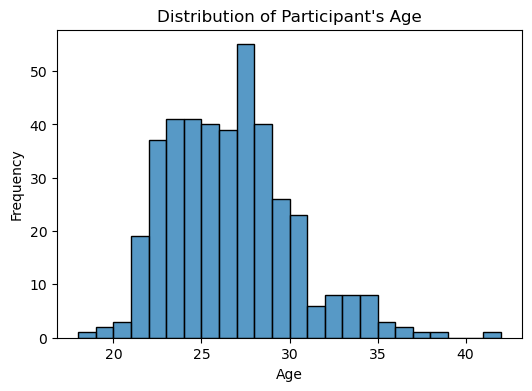

In [162]:
plt.figure(figsize = (6, 4))
sns.histplot(data = subject_df, x = subject_df['age'], binwidth = 1)
plt.title("Distribution of Participant's Age")
plt.xlabel("Age")
plt.ylabel('Frequency')
plt.show()

The mean age of participants was 26.2. The minimum age was 18, and the maximum age was 42. And from the histogram we could tell there were less observations for subjects aged below 20 or above 35. This implis our regression model might not be generalizable to these populations.

### Race

In [163]:
print(subject_df[["race"]].value_counts())

race                                 
European/Caucasian-American              234
Asian/Pacific Islander/Asian-American     90
Latino/Hispanic American                  32
Other                                     28
Black/African American                    21
Name: count, dtype: int64


Same problem here. Black/African American, Latino/Hispanic American, and international students were underrepresented compared to European/Caucasian-American and Asian/Pacific Islander/Asian American participants. This does not necessarily imply the data set is bad. Instead, doing this kind of descriptive statistics enables us to acknowledge the potential lack of generalizability of the models we make for the next phase to certain populations.

### Career and field

In [164]:
print(subject_df[["field"]].value_counts())

field                                         
Business/Econ/Finance                             104
Biological Sciences/Chemistry/Physics              47
Law                                                44
Political Science/International Affairs            38
Social Science, Psychologist                       36
Engineering                                        31
Education, Academia                                25
Social Work                                        23
History/Religion/Philosophy                        14
English/Creative Writing/Journalism                14
Math                                                9
Film                                                6
Medical Science, Pharmaceuticals, and Bio Tech      6
Fine Arts/Arts Administration                       3
Languages                                           3
Architecture                                        1
Undergrad/undecided                                 1
Name: count, dtype: int64


The problem of the data regarding participants' fields here was quite obvious. About 1/4 of the students were in Business/Econ/Finance-related fields. However, majors like Fine Arts/Arts Administration were underrepresented. Although we could use field as a predictor, this would not solve the problem with the data itself. Because we could not be confident in whether participants majoring in Fine Arts/Arts Administration could represent the whole population of students majoring in Fine Arts/Arts Administration – we just did not have enough data.